In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

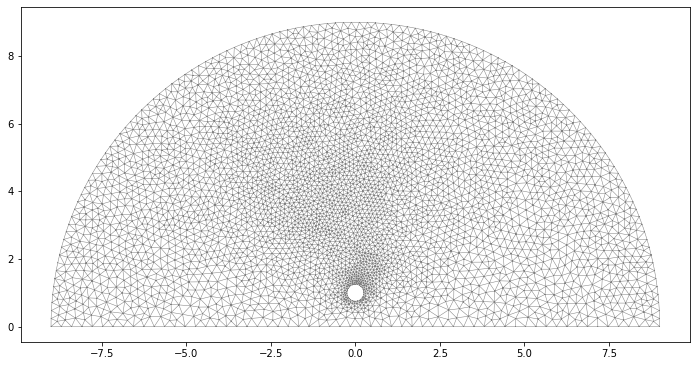

In [2]:
# Import mesh, subdomain and boundary information
mesh = fn.Mesh('diff_pair/geometry/diff_pair.xml')
subdomains = fn.MeshFunction("size_t", mesh, 'diff_pair/geometry/diff_pair_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'diff_pair/geometry/diff_pair_facet_region.xml')
plt.figure(figsize=(12, 7))
fn.plot(mesh, linewidth=0.5)
plt.savefig('diff_pair/plots/mesh.png', bbox_inches='tight')
plt.show()

In [3]:
# Define the function space
V = fn.FunctionSpace(mesh, 'CG', 2)

In [4]:
# Define measures for performing integrals
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
ds = fn.Measure('ds', domain=mesh, subdomain_data=boundaries)

In [5]:
# Define the boundary conditions
voltage = 25
inner_boundary = fn.DirichletBC(V, fn.Constant(voltage), boundaries, 2)
outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 1)
gnd = fn.DirichletBC(V, fn.Constant(0), boundaries, 3)
bcs =[inner_boundary, outer_boundary, gnd]

In [6]:
# Solve the Poisson Equation
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = fn.dot(fn.grad(u), fn.grad(v)) * dx
L = fn.Constant('0') * v * dx
u = fn.Function(V)
fn.solve(a == L, u, bcs)

# Electric Potential

In [7]:
# Define some constants
epsilon_r = 3

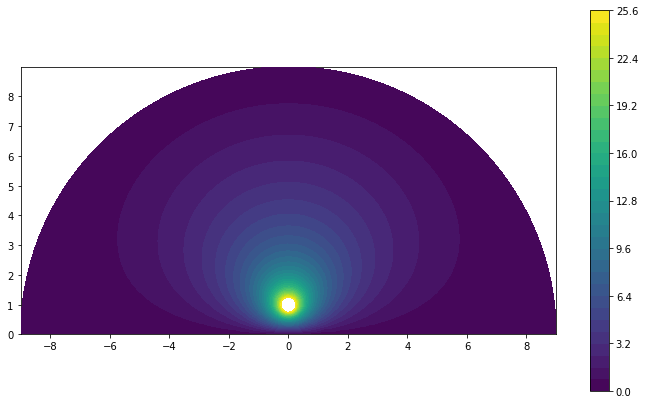

In [8]:
# Plot the electric potential
%matplotlib inline
plt.figure(figsize=(12,7))
pp = fn.plot(u, zorder=3)
plt.colorbar(pp)
plt.savefig('diff_pair/plots/electric_potential.png', bbox_inches='tight')
plt.show()

# Electric Field

In [9]:
# Calculate the displacement field from the gradient and plot
E = -fn.grad(u)

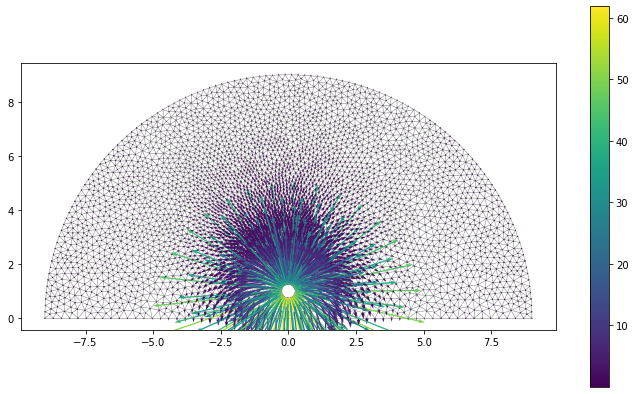

In [10]:
# Plot the electric field
%matplotlib inline
plt.figure(figsize=(12,7))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(E, zorder=3, scale=200)
plt.colorbar(p)
plt.savefig('diff_pair/plots/electric_field.png', bbox_inches='tight')
plt.show()

# H Field

In [11]:
# Define some unit vectors which will be used later
xhat = fn.Expression(('1.0', '0.0'), V, degree=1)
yhat = fn.Expression(('0.0', '1.0'), V, degree=1)

In [12]:
# calculate the H field
z_tem = fn.Constant(np.sqrt(mu_0/epsilon_0/epsilon_r))
e_x = fn.dot(E, xhat)
e_y = fn.dot(E, yhat)
h = 1/z_tem * fn.as_vector([-e_y, +e_x])

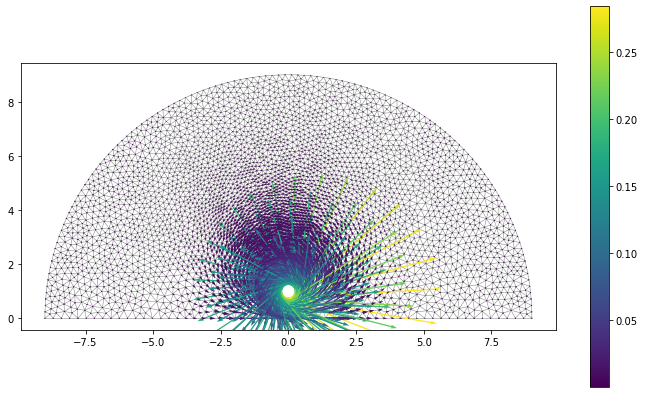

In [13]:
# Plot the H field
%matplotlib inline
plt.figure(figsize=(12,7))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(h, zorder=2, scale=1)
plt.colorbar(p)
plt.savefig('diff_pair/plots/h_field.png', bbox_inches='tight')
plt.show()

# Current and Characteristic Impedance

### Line Integral Method

0.3544782080764642


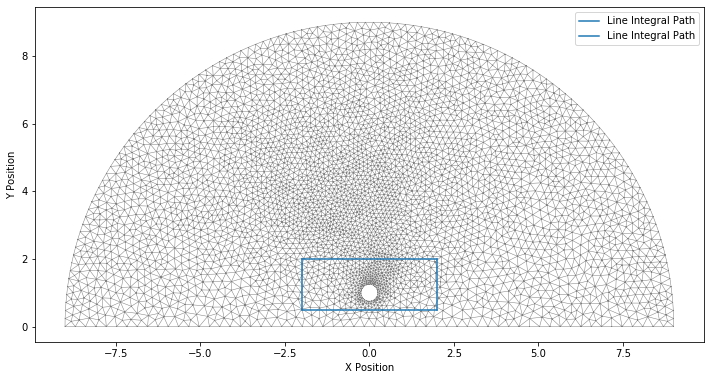

In [14]:
# Define an array with variable coordinate elements and constant
left = np.linspace(0.5, 2, 150)
bottom = np.linspace(-2, 2, 400)
right = left
top = bottom

# Project H so that we can evaluate it
projected_h = fn.project(h)

# Evaluate h on a vertical line with x coming from the array con
# and y coming from the array var. Put this into a numpy array.
h_right = np.array(list(map(projected_h, zip(np.ones(150)*2, right))))
h_left = np.array(list(map(projected_h, zip(-np.ones(150)*2, left))))

# Evaluate h on a horizontal line in the same way
h_top = np.array(list(map(projected_h, zip(top, np.ones(400)*2))))
h_bot = np.array(list(map(projected_h, zip(bottom, np.ones(400)*0.5))))

# Calculate the step-width from the var array
dl = left[1] - left[0]

# Integrate the evluated h field, taking care to obey the right
# hand rule.
current_1 = np.trapz(h_right[:, 1], dx=dl)
current_2 = np.trapz(h_top[:, 0], dx=-dl)
current_3 = np.trapz(h_left[:, 1], dx=-dl)
current_4 = np.trapz(h_bot[:, 0], dx=dl)

# Add the integrated field and multiply by 4 to account for the
# un-simulated regions
current = (current_1 + current_2 + current_3 + current_4)
print(current)

plt.figure(figsize=(12, 7))
fn.plot(mesh, linewidth=0.5)
plt.plot(np.ones(150)*2, right, 'C0', label='Line Integral Path')
plt.plot(np.ones(150)*-2, left, 'C0', label='Line Integral Path')
plt.plot(top, np.ones(400)*2, 'C0')
plt.plot(bottom, np.ones(400)*0.5, 'C0')
plt.legend(loc=0)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.savefig('diff_pair/plots/line_method.png', bbox_inches='tight')
plt.show()

### Surface Current Method

In [15]:
# calculate current from surface current
nhat = fn.FacetNormal(mesh)
k = (fn.dot(h, yhat) * fn.dot(nhat, xhat) - fn.dot(nhat, yhat) * fn.dot(h, xhat))
current_2 = fn.assemble(-k * ds(2))
print(current_2)

0.34592077831242757


In [16]:
# integration over area and line to check surfaces are as-expected

# print(fn.assemble(1 * dx(1))) ## pi*9**2 - 2*(pi*0.5**2) = 252.9
# print(fn.assemble(1 * ds(2)))  # 2*pi*1.5 = 9.42

## Characteristic Impedance

In [17]:
# Calculate z0 and print the result from both of the calculated currents
z_0 = np.abs((2*voltage)/current)
print(z_0)
print(z_0 * current / current_2)

141.05239436669277
144.54176544099113


# Poynting Vector

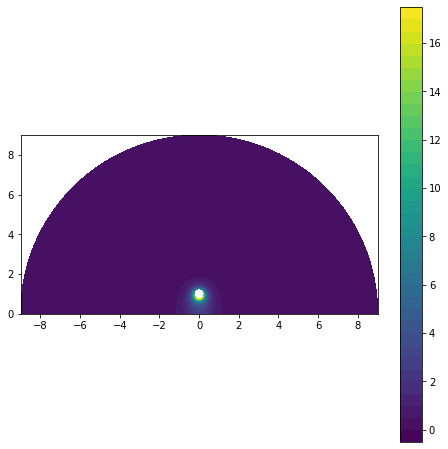

In [18]:
# Calculate the peak Poynting vector
S = (fn.dot(E, xhat)*fn.dot(h, yhat) -
           fn.dot(E,yhat)*fn.dot(h, xhat))

plt.figure(figsize=(8,8))
p = fn.plot(S, zorder=2)
plt.colorbar(p)
plt.savefig('diff_pair/plots/poynting.png', bbox_inches='tight')
plt.show()

In [19]:
peak_power = fn.assemble(S * dx(4)) * 2
print("Z_0 = {:.2f}".format((2*voltage)**2 / peak_power))
print("Current = {:.2f}".format(peak_power/(2*voltage)))

Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/lib/python3/dist-packages/ffc/uflacs/analysis/dependencies.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Z_0 = 141.51
Current = 0.35


In [20]:
electric_potential_file = fn.File('diff_pair/output/electric_potential.pvd')
electric_potential_file << fn.project(u/epsilon_r)

electric_field_file = fn.File('diff_pair/output/electric_field.pvd')
electric_field_file << fn.project(E)

h_field_file = fn.File('diff_pair/output/h_field.pvd')
h_field_file << fn.project(h)